## ISIC Skin Cancer Image Segmention ##

In [ ]:
#Libraries
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import f1_score, jaccard_score, average_precision_score
from tqdm import tqdm


C:\Users\mudda\anaconda3\envs\torch-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\mudda\anaconda3\envs\torch-gpu\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


##### The class ISICDataset(Dataset) is created to handle image-mask pairs from the ISIC dataset for semantic segmentation task.
 #####

In [ ]:
class ISICDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.images = []
        for fname in sorted(os.listdir(image_dir)):
            if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            img_path = os.path.join(image_dir, fname)
            base_name = os.path.splitext(fname)[0]
            mask_name = base_name + '_segmentation.png'
            mask_path = os.path.join(mask_dir, mask_name)

            if (
                os.path.exists(img_path) and os.path.exists(mask_path) and
                cv2.imread(img_path) is not None and
                cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) is not None
            ):
                self.images.append(fname)

        print(f"Total valid image-mask pairs: {len(self.images)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_filename = self.images[idx]
        base_name = os.path.splitext(img_filename)[0]
        mask_filename = base_name + '_segmentation.png'

        img_path = os.path.join(self.image_dir, img_filename)
        mask_path = os.path.join(self.mask_dir, mask_filename)

        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found or unreadable: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found or unreadable: {mask_path}")

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = transforms.ToTensor()(image)
        mask = torch.tensor(mask / 255.0, dtype=torch.float32).unsqueeze(0)

        return image, mask


### Data Augmentation and DataLoader

### Transformations with Albumentations

#### performed data augmentation and preprocessing transformations using the `Albumentations` library ####

In [ ]:
train_tfms = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
])
train_dataset = ISICDataset(
    image_dir='C:/Users/mudda/Downloads/SANA/Seg_Data/ISIC2018_Task1-2_Training_Input',
    mask_dir='C:/Users/mudda/Downloads/SANA/Seg_Data/ISIC2018_Task1_Training_GroundTruth',
    transform=train_tfms
)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


Total valid image-mask pairs: 2594


### Model Definition and Training Setup

#### We have used pre-built architectures like U-Net with encoder resnet34 and encoder_weight imagenet. This is binary segmentation. ####

In [ ]:
#Set device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Define U-Net model
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)
model.to(device)

# custom loss (Dice + Jaccard)
class CombinedLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = smp.losses.DiceLoss(mode='binary')
        self.jaccard = smp.losses.JaccardLoss(mode='binary')

    def forward(self, y_pred, y_true):
        return self.dice(y_pred, y_true) + self.jaccard(y_pred, y_true)

loss_fn = CombinedLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda


### Training Loop and Loss Curve Visualization
##### The training loop for the U-Net segmentation model and visualizes the training losses #####

100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [06:32<00:00,  1.21s/it]


Epoch 1/10 - Loss: 0.7506


100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [06:36<00:00,  1.22s/it]


Epoch 2/10 - Loss: 0.4251


100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [06:36<00:00,  1.22s/it]


Epoch 3/10 - Loss: 0.3430


100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [06:40<00:00,  1.23s/it]


Epoch 4/10 - Loss: 0.3058


100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [06:38<00:00,  1.23s/it]


Epoch 5/10 - Loss: 0.2840


100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [06:40<00:00,  1.23s/it]


Epoch 6/10 - Loss: 0.2592


100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [06:40<00:00,  1.23s/it]


Epoch 7/10 - Loss: 0.2396


100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [06:38<00:00,  1.23s/it]


Epoch 8/10 - Loss: 0.2421


100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [06:42<00:00,  1.24s/it]


Epoch 9/10 - Loss: 0.2644


100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [06:38<00:00,  1.23s/it]

Epoch 10/10 - Loss: 0.2349


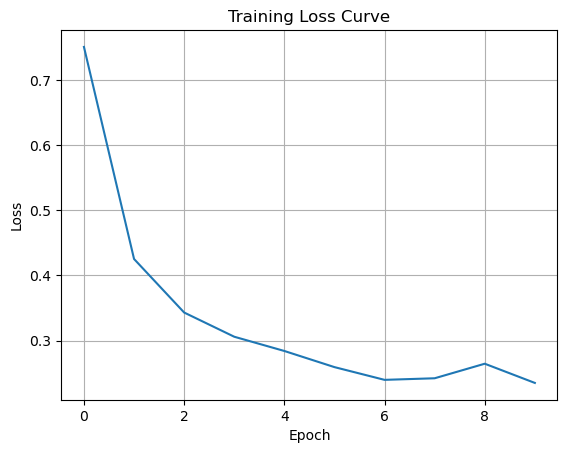

In [ ]:
import matplotlib.pyplot as plt

def train(model, loader, epochs=10):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0
        for imgs, masks in tqdm(loader):
            imgs, masks = imgs.to(device), masks.to(device)

            preds = model(imgs)
            loss = loss_fn(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    return loss_history

# Call and plot
losses = train(model, train_loader, epochs=10)
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()


#### Save the model ####

In [ ]:
torch.save(model.state_dict(), "unet_isic2018_trained.pth")
print(" Model saved!")


 Model saved!


### Loading Pretrained U-Net Model ###

In [ ]:
# Rebuild model architecture
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)
model.load_state_dict(torch.load("unet_isic2018_trained.pth"))
model.to(device)
model.eval()


C:\Users\mudda\AppData\Local\Temp\ipykernel_32148\1628943969.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_isic2018_trained.pth"

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Validation ###

In [ ]:
val_dataset = ISICDataset(
    image_dir='C:/Users/mudda/Downloads/SANA/Seg_Data/ISIC2018_Task1-2_Validation_Input',
    mask_dir='C:/Users/mudda/Downloads/SANA/Seg_Data/ISIC2018_Task1_Validation_GroundTruth',
    transform=train_tfms
)

val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


Total valid image-mask pairs: 100


### Model Evaluation Val+Test ###
#### The  function evaluates the trained segmentation model on a given dataset using **Dice coefficient**, **IoU**, and **mean Average Precision (mAP)**. ####


In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for imgs, masks in tqdm(dataloader, desc="Validating"):
            imgs = imgs.to(device)
            preds = model(imgs)
            preds = torch.sigmoid(preds).cpu().numpy()
            masks = masks.cpu().numpy()

            preds = (preds > 0.5).astype(np.uint8)

            for i in range(len(preds)):
                y_true.extend(masks[i][0].flatten())
                y_pred.extend(preds[i][0].flatten())

    dice = f1_score(y_true, y_pred)
    iou = jaccard_score(y_true, y_pred)
    map_score = average_precision_score(y_true, y_pred)

    print("\n Validation Metrics:")
    print(f"Dice Coefficient : {dice:.4f}")
    print(f"IoU Score        : {iou:.4f}")
    print(f"mAP Score        : {map_score:.4f}")


In [ ]:
evaluate_model(model, val_loader)


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]



 Validation Metrics:
Dice Coefficient : 0.8895
IoU Score        : 0.8009
mAP Score        : 0.8251


### Testing ####

In [ ]:
test_dataset = ISICDataset(
    image_dir='C:/Users/mudda/Downloads/SANA/Seg_Data/ISIC2018_Task1-2_Test_Input',
    mask_dir='C:/Users/mudda/Downloads/SANA/Seg_Data/ISIC2018_Task1_Test_GroundTruth',
    transform=train_tfms
)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


Total valid image-mask pairs: 1000


In [ ]:
evaluate_model(model, test_loader)


Validating: 100%|████████████████████████████████████████████████████████████████████| 125/125 [01:48<00:00,  1.16it/s]



 Validation Metrics:
Dice Coefficient : 0.8847
IoU Score        : 0.7933
mAP Score        : 0.8211


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


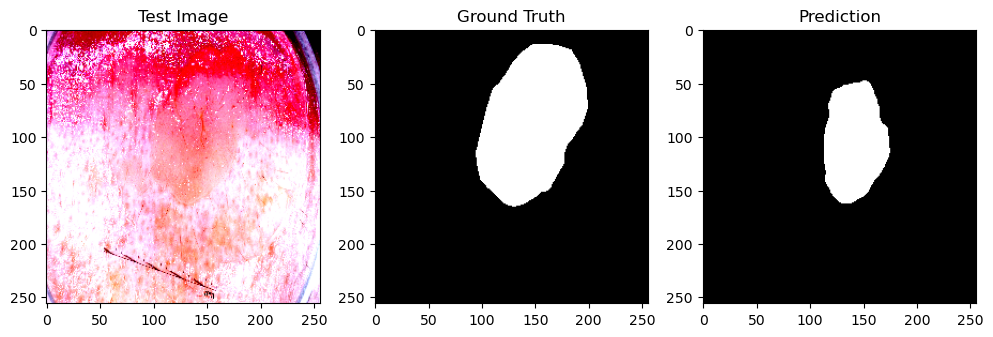

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


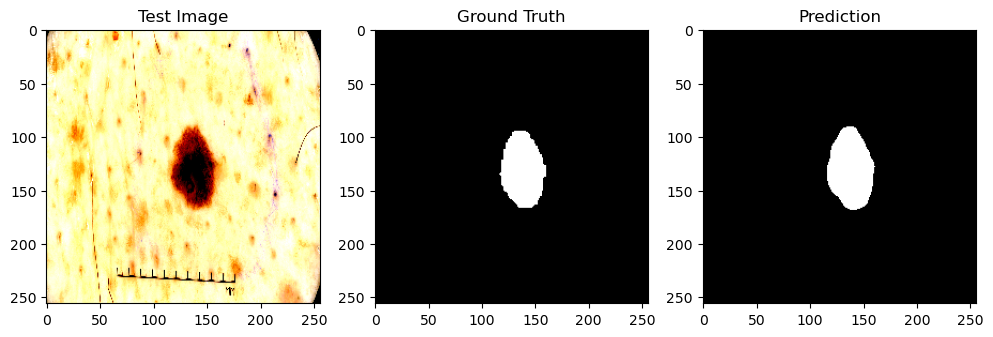

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


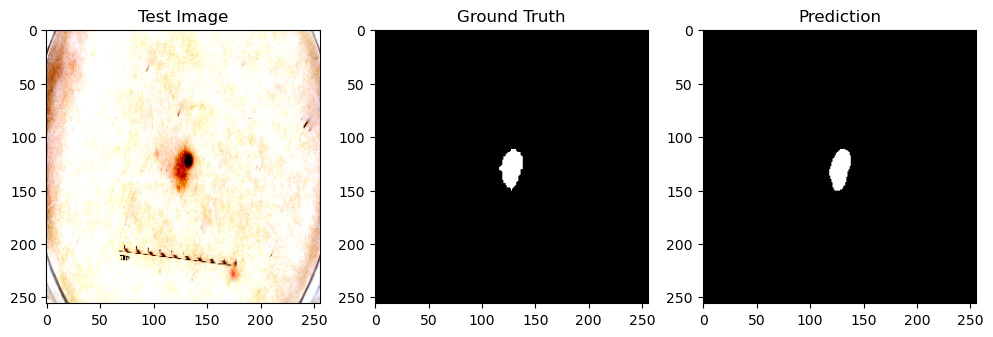

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


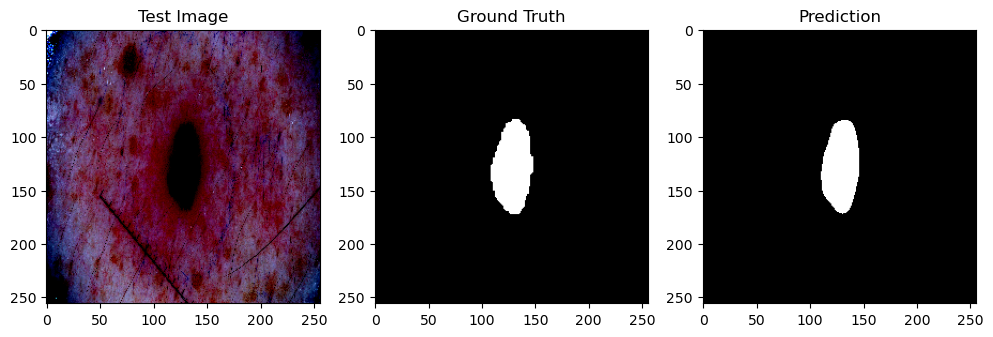

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


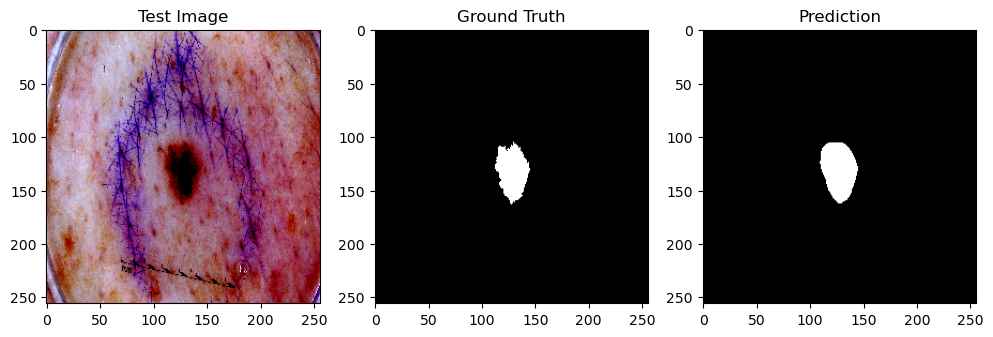

In [ ]:
def show_test_predictions(n=5):
    model.eval()
    for i in range(n):
        image, mask = test_dataset[i]
        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(device))
            pred = torch.sigmoid(pred).cpu().numpy()[0, 0]
            pred = (pred > 0.5).astype(np.uint8)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title("Test Image")

        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap='gray')
        plt.title("Prediction")

        plt.show()

show_test_predictions(5)


#### Generating binary segmentation masks for each test image using the trained model and saving it ####

In [ ]:
import os
os.makedirs("test_outputs", exist_ok=True)

model.eval()
for i in range(len(test_dataset)):
    image, _ = test_dataset[i]
    img_id = os.path.splitext(test_dataset.images[i])[0]

    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device))
        pred = torch.sigmoid(pred).cpu().numpy()[0, 0]
        pred = (pred > 0.5).astype(np.uint8)

    pred_path = f"test_outputs/{img_id}_pred.png"
    cv2.imwrite(pred_path, pred * 255)
